

We analyze the effects of Alpenglow and SIMD-228 on validator profitability and distribution. We use Helius' dataset on all Solana Validators in data/validator_profit.csv. To begin, we'll look at the dataset and analyze the status quo with no Alpenglow or SIMD-228.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygal


from IPython.display import SVG, display
import sys

sys.path.append('../')

from scripts.utils import *
from scripts.linebar import LineBar
s_quo = pd.read_csv('../data/validator_profit.csv')
s_quo.head()


,Rank,Validator Name,Validator Vote Account,Active Stake (SOL),Percentage of total stake (%),Cumulative Stake (%),Issuance Rewards Commission (%),Jito MEV Commission Rate (%),Issuance Revenue (SOL),Issuance Revenue as % of Total Revenue (%),Jito MEV Revenue (SOL),Jito MEV Revenue as % of Total Revenue (%),Block Rewards Revenue (SOL),Block Rewards Revenue as % of Total Revenue (%),Total Revenue (SOL),Server Cost (SOL),Voting Cost (SOL),Profit(SOL),Profitable
0,1,Helius,he1iusunGwqrNtafDtLdhsUQDFvo13z9sUa36PauBtk,13356080.98,0.03554,0.036,0.00,0.00,0.00,0.0000,0.00,0.0000,174465.76,1.0000,174465.76,133.33,365,173967.42,YES
1,2,Binance Staking,3N7s9zXMZ4QqvHQR15t5GNHyqc89KduzMP7423eWiD5g,11506125.17,0.03062,0.066,0.08,0.10,63261.34,0.2758,15821.10,0.0690,150300.44,0.6552,229382.88,133.33,365,228884.55,YES
2,3,Coinbase 02,6D2jqw9hyVCpppZexquxa74Fn33rJzzBx38T58VucHx9,10022736.57,0.02667,0.093,0.08,0.08,55105.59,0.2796,11025.13,0.0559,130923.46,0.6644,197054.18,133.33,365,196555.85,YES
3,4,Galaxy,CvSb7wdQAFpHuSpTYTJnX5SYH4hCfQ9VuGnqrKaKwycB,8975929.50,0.02389,0.117,0.05,0.25,30843.86,0.1724,30855.10,0.1724,117249.39,0.6552,178948.35,133.33,365,178450.02,YES
4,5,Ledger by Figment,26pV97Ce83ZQ6Kz9XT4td8tdoUFPTng8Fb8gPyc53dJx,8567673.97,0.02280,0.140,0.07,0.07,41217.37,0.2554,8246.48,0.0511,111916.49,0.6935,161380.34,133.33,365,160882.01,YES


/var/folders/g8/htn76nmn625fn9k4_20hws7c0000gn/T/ipykernel_67022/1556739048.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  s_quo.groupby(stake_binned)['Active Stake (SOL)']


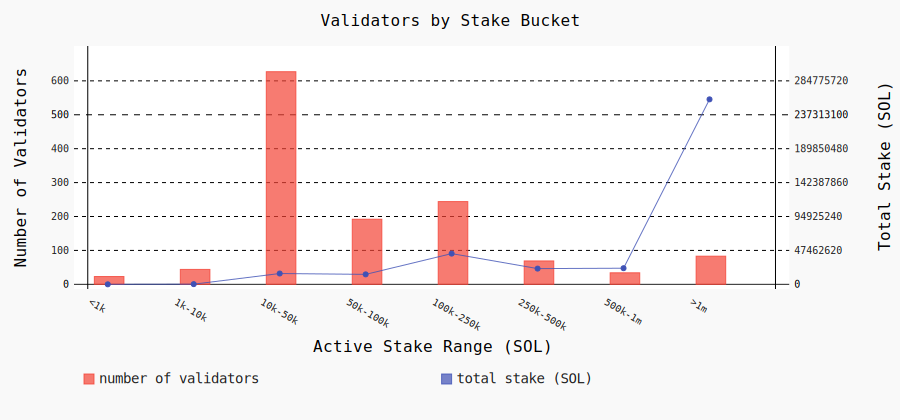

In [ ]:
# --- bin + aggregate ---
stake_bins = [0, 1_000, 10_000, 50_000, 100_000, 250_000, 500_000, 1_000_000,
              s_quo['Active Stake (SOL)'].max() + 1]
bin_labels = ['<1k','1k-10k','10k-50k','50k-100k','100k-250k','250k-500k','500k-1m','>1m']

stake_binned = pd.cut(
    s_quo['Active Stake (SOL)'],
    bins=stake_bins, labels=bin_labels, right=False, include_lowest=True
)

validator_counts = stake_binned.value_counts().reindex(bin_labels, fill_value=0)
stake_per_bucket = (
    s_quo.groupby(stake_binned)['Active Stake (SOL)']
    .sum()
    .reindex(bin_labels, fill_value=0)
)

counts    = [int(validator_counts.get(lb, 0)) for lb in bin_labels]
stake_sol = [float(stake_per_bucket.get(lb, 0.0)) for lb in bin_labels]

# --- chart config ---
config = pygal.Config()
config.human_readable = True
config.legend_at_bottom = True
config.legend_at_bottom_columns = 2
config.x_label_rotation = 30
config.print_values = False
config.interpolate = False

# format axes
config.value_formatter = lambda x: str(int(x))  # counts on left axis
def fmt_sol(value):
    if value >= 1_000_000:
        return f"{value/1_000_000:.1f}M"
    elif value >= 1_000:
        return f"{value/1_000:.1f}k"
    return str(int(value))
config.secondary_value_formatter = fmt_sol

# CSS nudge to center line
SHIFT_PX = 20
config.css.append(f'''inline:
  g.plot.overlay g.serie-1, g.graph g.serie-1 {{
    transform: translate({SHIFT_PX}px, 0);
  }}''')

# ranges
primary_range   = (0, int(max(5, (max(counts) if counts else 0) * 1.1)))
secondary_range = (0, max(1.0, (max(stake_sol) if stake_sol else 0.0) * 1.1))

style = pygal.style.DefaultStyle(value_font_size=10)

chart = LineBar(
    config,
    width=900,
    height=420,
    title="Validators by Stake Bucket",
    x_title="Active Stake Range (SOL)",
    y_title="Number of Validators",
    y_title_secondary="Total Stake (SOL)",
    legend_box_size=10,
    range=primary_range,
    secondary_range=secondary_range,
    style=style,
    human_readable=True,
    format_secondary_value=fmt_sol,
)

chart.x_labels = bin_labels
chart.x_labels.append("")  # prevent last bar overlap janky pygal workaround

chart.add("number of validators", counts, plotas='bar')
chart.add("total stake (SOL)", stake_sol, plotas='line', secondary=True)

display(SVG(chart.render()))


In [3]:
# remove the css nudge to avoid affecting future charts
if f'''inline:
  g.plot.overlay g.serie-1, g.graph g.serie-1 {{
    transform: translate({SHIFT_PX}px, 0);
  }}''' in config.css:
    config.css.remove(f'''inline:
  g.plot.overlay g.serie-1, g.graph g.serie-1 {{
    transform: translate({SHIFT_PX}px, 0);
  }}''')


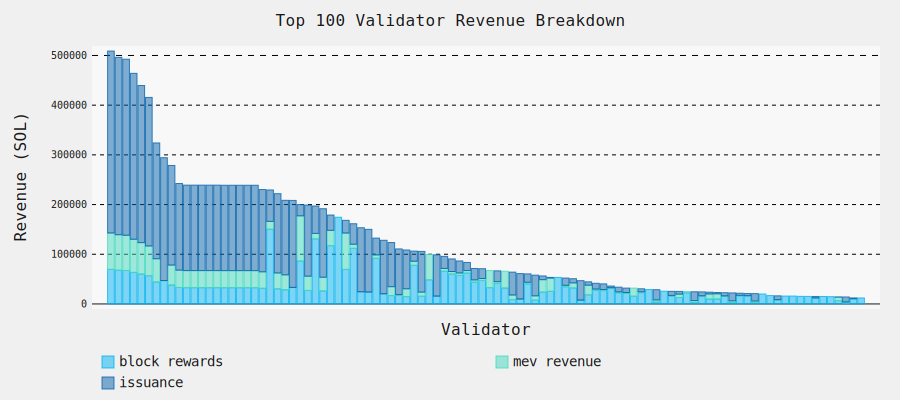

In [4]:

# calculate block rewards revenue
block_rewards = s_quo['Total Revenue (SOL)'] * s_quo['Block Rewards Revenue as % of Total Revenue (%)']
issuance = s_quo['Issuance Revenue (SOL)'].astype(float)
mev_revenue = s_quo['Jito MEV Revenue (SOL)'].astype(float)

top_n = 100
s_quo_sorted = s_quo.sort_values('Total Revenue (SOL)', ascending=False).head(top_n)
block_rewards = block_rewards.loc[s_quo_sorted.index]
mev_revenue = mev_revenue.loc[s_quo_sorted.index]
issuance = issuance.loc[s_quo_sorted.index]


chart = pygal.StackedBar(
    title='Top 100 Validator Revenue Breakdown',
    x_title='Validator',
    y_title='Revenue (SOL)',
    style=pygal.style.BlueStyle,
    width=900,
    height=400,
    x_label_rotation=30,
    show_legend=True,
    human_readable=True,
    legend_at_bottom=True,
    
    print_values=False,
)

# chart.x_labels = validator_names

chart.add('block rewards', [round(v, 2) for v in block_rewards])
chart.add('mev revenue', [round(v, 2) for v in mev_revenue])
if issuance.sum() > 0:
    chart.add('issuance', [round(v, 2) for v in issuance])

display(SVG(chart.render()))
# chart.render_to_file('validator_total_revenue_breakdown.svg')


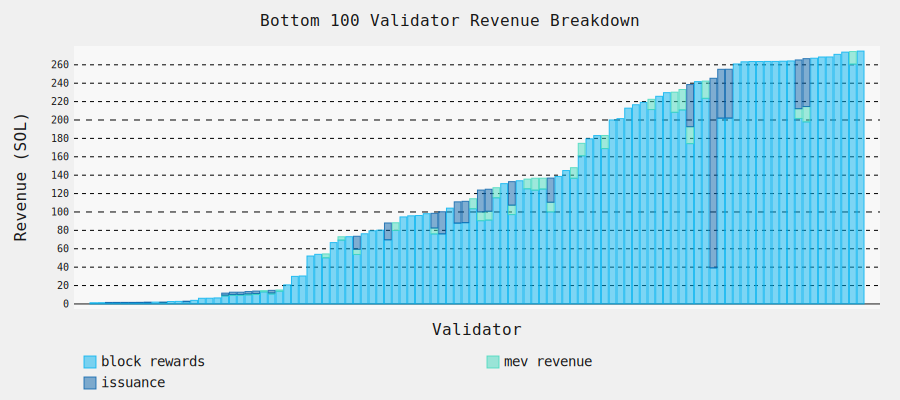

In [ ]:
# select bottom 100 validators by total revenue
bottom_n = 100
s_quo_sorted = s_quo.sort_values('Total Revenue (SOL)', ascending=True).head(bottom_n)
block_rewards = s_quo_sorted['Total Revenue (SOL)'] * s_quo_sorted['Block Rewards Revenue as % of Total Revenue (%)']
mev_revenue = s_quo_sorted['Jito MEV Revenue (SOL)'].astype(float)
issuance = s_quo_sorted['Issuance Revenue (SOL)'].astype(float)


chart_bottom = pygal.StackedBar(
    title='Bottom 100 Validator Revenue Breakdown',
    x_title='Validator',
    y_title='Revenue (SOL)',
    style=pygal.style.BlueStyle,
    width=900,
    height=400,
    x_label_rotation=30,
    show_legend=True,
    human_readable=True,
    legend_at_bottom=True,
    print_values=False,
)

chart_bottom.add('block rewards', [round(v, 2) for v in block_rewards])
chart_bottom.add('mev revenue', [round(v, 2) for v in mev_revenue])
if issuance is not None and issuance.sum() > 0:
    chart_bottom.add('issuance', [round(v, 2) for v in issuance])

display(SVG(chart_bottom.render()))


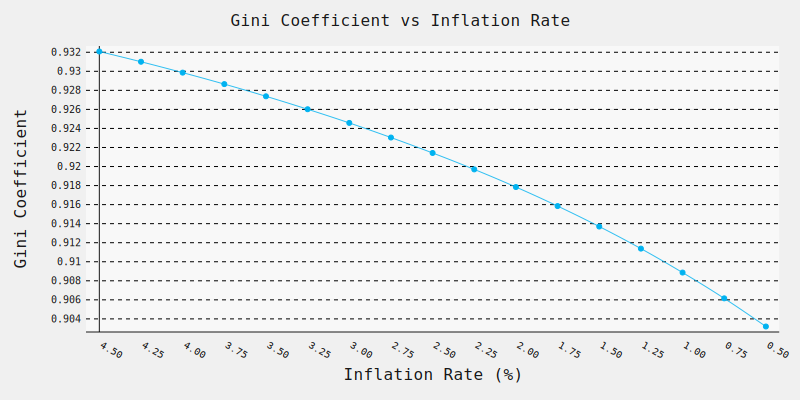

In [ ]:
gini_improvements = calculate_gini_inflation_ratio(s_quo)

line_chart = pygal.Line(
    title='Gini Coefficient vs Inflation Rate',
    x_title='Inflation Rate (%)',
    y_title='Gini Coefficient',
    style=pygal.style.BlueStyle,
    width=800,
    height=400,
    show_legend=False,
    x_label_rotation=30,
    human_readable=True,
    interpolate='cubic'
)

inflation_rates = [float(imp['inflation_rate']) for imp in gini_improvements]
gini_coefficients = [float(imp['gini_coefficient']) for imp in gini_improvements]

# set x labels as inflation rates formatted to 2 decimals
line_chart.x_labels = [f"{rate:.2f}" for rate in inflation_rates]
line_chart.add('gini coefficient', gini_coefficients)

display(SVG(line_chart.render()))


/Users/mustafaqazi/research/Solana-Validator-Analysis/notebooks/../scripts/utils.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('stake_bucket')['Profit(SOL)']


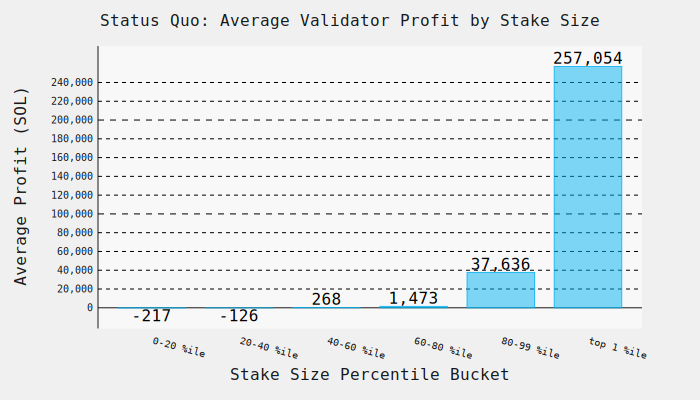

Gini Coefficient: 0.93
Shannon Entropy: 0.64


In [ ]:
s_quo_local = s_quo.copy()
chart = profit_distribution_chart(s_quo_local, 'Status Quo: Average Validator Profit by Stake Size')

display(SVG(chart.render()))

gini = calc_modified_gini(s_quo_local)
shannon = calc_shannon_entropy(s_quo_local)
print(f"Gini Coefficient: {gini:.2f}")
print(f"Shannon Entropy: {shannon:.2f}")


/Users/mustafaqazi/research/Solana-Validator-Analysis/notebooks/../scripts/utils.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('stake_bucket')['Profit(SOL)']


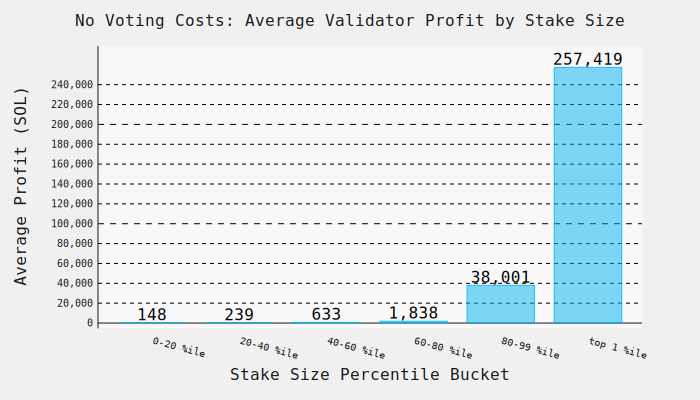

Gini Coefficient: 0.91%
Shannon Entropy: 0.66


In [ ]:
alpenglow_no_vote = s_quo.copy()
# set voting cost to zero and recompute profits
alpenglow_no_vote = change_vote_fees(alpenglow_no_vote, 0)
alpenglow_no_vote = recompute_profits(alpenglow_no_vote)


chart = profit_distribution_chart(alpenglow_no_vote, 'No Voting Costs: Average Validator Profit by Stake Size')

display(SVG(chart.render()))


gini = calc_modified_gini(alpenglow_no_vote)
shannon = calc_shannon_entropy(alpenglow_no_vote)
print(f"Gini Coefficient: {gini:.2f}%")
print(f"Shannon Entropy: {shannon:.2f}")

/Users/mustafaqazi/research/Solana-Validator-Analysis/notebooks/../scripts/utils.py:151: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('stake_bucket')['Profit(SOL)']


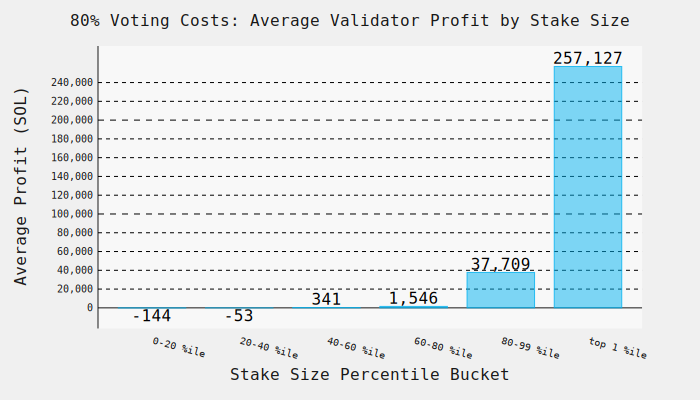

Gini Coefficient: 0.93%
Shannon Entropy: 0.65


In [ ]:
df = s_quo.copy()
df = change_vote_fees(df, 0.8)
df = recompute_profits(df)

chart = profit_distribution_chart(df, '80% Voting Costs: Average Validator Profit by Stake Size')

display(SVG(chart.render()))


gini = calc_modified_gini(df)
shannon = calc_shannon_entropy(df)
print(f"Gini Coefficient: {gini:.2f}%")
print(f"Shannon Entropy: {shannon:.2f}")

In [10]:

df = load_and_clean_data('../data/validator_profit.csv')

low_stake = apply_simd228(change_vote_fees(df, 0.135), 0.4, 0.02)
med_stake = apply_simd228(change_vote_fees(df, 0.135), 0.6, 0.02)
high_stake = apply_simd228(change_vote_fees(df, 0.135), 0.85, 0.02)

low_stake = recompute_profits(low_stake)
med_stake = recompute_profits(med_stake)
high_stake = recompute_profits(high_stake)

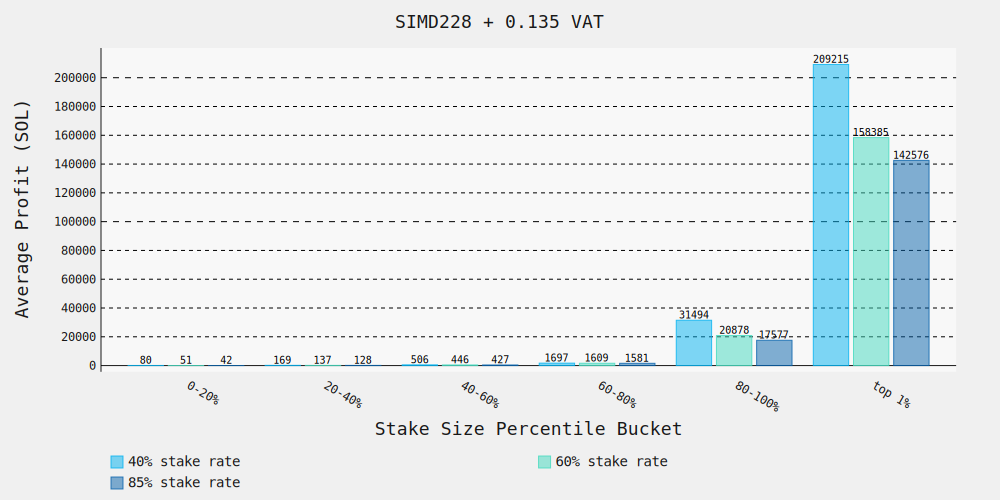

gini coefficient for low stake regime profit: 0.9082
gini coefficient for medium stake regime profit: 0.8884
gini coefficient for high stake regime profit: 0.8793
shannon entropy for low stake regime profit: 0.6738
shannon entropy for medium stake regime profit: 0.7047
shannon entropy for high stake regime profit: 0.7167


In [ ]:

def bucket_profits_with_top1(df, num_buckets=5):
    # keep only relevant columns and sort by stake
    df = df[['Active Stake (SOL)', 'Profit(SOL)']].dropna().sort_values('Active Stake (SOL)').reset_index(drop=True)
    n = len(df)
    # determine the cutoff for the top 1 percentile
    top1_cutoff = int(np.ceil(n * 0.99))
    # assign all but the top 1% to quantile buckets, top 1% to a separate bucket
    bucket_labels = [f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)] + ['top 1%']
    bucket_assignment = pd.Series([None] * n)
    # assign quantile buckets to the first 99%
    if top1_cutoff > 0:
        bucket_assignment.iloc[:top1_cutoff] = pd.qcut(
            np.arange(top1_cutoff), num_buckets, labels=[f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)]
        )
    # assign 'top 1%' to the last 1%
    bucket_assignment.iloc[top1_cutoff:] = 'top 1%'
    df['bucket'] = bucket_assignment

    grouped = df.groupby('bucket', observed=True)['Profit(SOL)']
    avg_profits = grouped.mean().reindex(bucket_labels).tolist()
    total_profits = grouped.sum().reindex(bucket_labels).tolist()
    labels = bucket_labels

    return labels, avg_profits, total_profits

# compute for each scenario
labels, low_avg, low_total = bucket_profits_with_top1(low_stake, num_buckets=5)
_, med_avg, med_total = bucket_profits_with_top1(med_stake, num_buckets=5)
_, high_avg, high_total = bucket_profits_with_top1(high_stake, num_buckets=5)

# create a custom style with smaller value font size
custom_style = pygal.style.BlueStyle(
    value_font_size=10,
    label_font_size=12,
    major_label_font_size=12,
    legend_font_size=14,
    tooltip_font_size=12,
    title_font_size=18,
)

chart = pygal.Bar(
    title='SIMD228 + 0.135 VAT',
    x_title='Stake Size Percentile Bucket',
    y_title='Average Profit (SOL)',
    width=1000,
    height=500,
    show_legend=True,
    legend_at_bottom=True,
    style=custom_style,
    human_readable=True,
    value_formatter=lambda x: f'{x:.0f}',
    show_y_guides=True,
    print_values=True,
    print_values_position='top',
    x_label_rotation=30,  # rotate x axis labels for readability
)

chart.x_labels = labels
chart.add('40% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(low_avg, low_total)])
chart.add('60% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(med_avg, med_total)])
chart.add('85% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(high_avg, high_total)])

display(SVG(chart.render()))


# calculate and print gini coefficient for each regime's profit
low_gini = calc_modified_gini(low_stake)
med_gini = calc_modified_gini(med_stake)
high_gini = calc_modified_gini(high_stake)

low_shannon = calc_shannon_entropy(low_stake)
med_shannon = calc_shannon_entropy(med_stake)
high_shannon = calc_shannon_entropy(high_stake) 

print('gini coefficient for low stake regime profit:', f'{low_gini:.4f}')
print('gini coefficient for medium stake regime profit:', f'{med_gini:.4f}')
print('gini coefficient for high stake regime profit:', f'{high_gini:.4f}')

print('shannon entropy for low stake regime profit:', f'{low_shannon:.4f}')
print('shannon entropy for medium stake regime profit:', f'{med_shannon:.4f}')
print('shannon entropy for high stake regime profit:', f'{high_shannon:.4f}')



In [12]:

df = load_and_clean_data('../data/validator_profit.csv')

low_stake = apply_simd228(df, 0.4, 0.02)
med_stake = apply_simd228(df, 0.6, 0.02)
high_stake = apply_simd228(df, 0.85, 0.02)

low_stake = recompute_profits(low_stake)
med_stake = recompute_profits(med_stake)
high_stake = recompute_profits(high_stake)


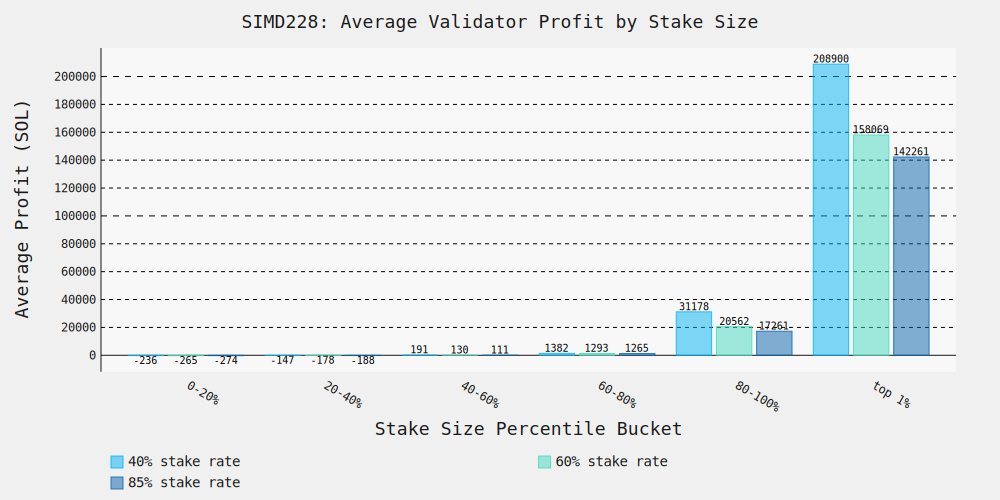

gini coefficient for low stake regime profit: 0.9248
gini coefficient for medium stake regime profit: 0.9086
gini coefficient for high stake regime profit: 0.9012
shannon entropy for low stake regime profit: 0.6556
shannon entropy for medium stake regime profit: 0.6827
shannon entropy for high stake regime profit: 0.6930


In [ ]:

def bucket_profits_with_top1(df, num_buckets=5):
    # keep only relevant columns and sort by stake
    df = df[['Active Stake (SOL)', 'Profit(SOL)']].dropna().sort_values('Active Stake (SOL)').reset_index(drop=True)
    n = len(df)
    # determine the cutoff for the top 1 percentile
    top1_cutoff = int(np.ceil(n * 0.99))
    # assign all but the top 1% to quantile buckets, top 1% to a separate bucket
    bucket_labels = [f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)] + ['top 1%']
    bucket_assignment = pd.Series([None] * n)
    # assign quantile buckets to the first 99%
    if top1_cutoff > 0:
        bucket_assignment.iloc[:top1_cutoff] = pd.qcut(
            np.arange(top1_cutoff), num_buckets, labels=[f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)]
        )
    # assign 'top 1%' to the last 1%
    bucket_assignment.iloc[top1_cutoff:] = 'top 1%'
    df['bucket'] = bucket_assignment

    grouped = df.groupby('bucket', observed=True)['Profit(SOL)']
    avg_profits = grouped.mean().reindex(bucket_labels).tolist()
    total_profits = grouped.sum().reindex(bucket_labels).tolist()
    labels = bucket_labels

    return labels, avg_profits, total_profits

# compute for each scenario
labels, low_avg, low_total = bucket_profits_with_top1(low_stake, num_buckets=5)
_, med_avg, med_total = bucket_profits_with_top1(med_stake, num_buckets=5)
_, high_avg, high_total = bucket_profits_with_top1(high_stake, num_buckets=5)


# create a custom style with smaller value font size
custom_style = pygal.style.BlueStyle(
    value_font_size=10,
    label_font_size=12,
    major_label_font_size=12,
    legend_font_size=14,
    tooltip_font_size=12,
    title_font_size=18,
)

chart = pygal.Bar(
    title='SIMD228: Average Validator Profit by Stake Size',
    x_title='Stake Size Percentile Bucket',
    y_title='Average Profit (SOL)',
    width=1000,
    height=500,
    show_legend=True,
    legend_at_bottom=True,
    style=custom_style,
    human_readable=True,
    value_formatter=lambda x: f'{x:.0f}',
    show_y_guides=True,
    print_values=True,
    print_values_position='top',
    x_label_rotation=30,  # rotate x axis labels for readability
)

chart.x_labels = labels
chart.add('40% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(low_avg, low_total)])
chart.add('60% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(med_avg, med_total)])
chart.add('85% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(high_avg, high_total)])

display(SVG(chart.render()))


# calculate and print gini coefficient for each regime's profit
low_gini = calc_modified_gini(low_stake)
med_gini = calc_modified_gini(med_stake)
high_gini = calc_modified_gini(high_stake)

low_shannon = calc_shannon_entropy(low_stake)
med_shannon = calc_shannon_entropy(med_stake)
high_shannon = calc_shannon_entropy(high_stake) 

print('gini coefficient for low stake regime profit:', f'{low_gini:.4f}')
print('gini coefficient for medium stake regime profit:', f'{med_gini:.4f}')
print('gini coefficient for high stake regime profit:', f'{high_gini:.4f}')

print('shannon entropy for low stake regime profit:', f'{low_shannon:.4f}')
print('shannon entropy for medium stake regime profit:', f'{med_shannon:.4f}')
print('shannon entropy for high stake regime profit:', f'{high_shannon:.4f}')



In [14]:

df = load_and_clean_data('../data/validator_profit.csv')

low_stake = apply_simd228(df, 0.4)
med_stake = apply_simd228(df, 0.6)
high_stake = apply_simd228(df, 0.85)

low_stake = recompute_profits(low_stake)
med_stake = recompute_profits(med_stake)
high_stake = recompute_profits(high_stake)


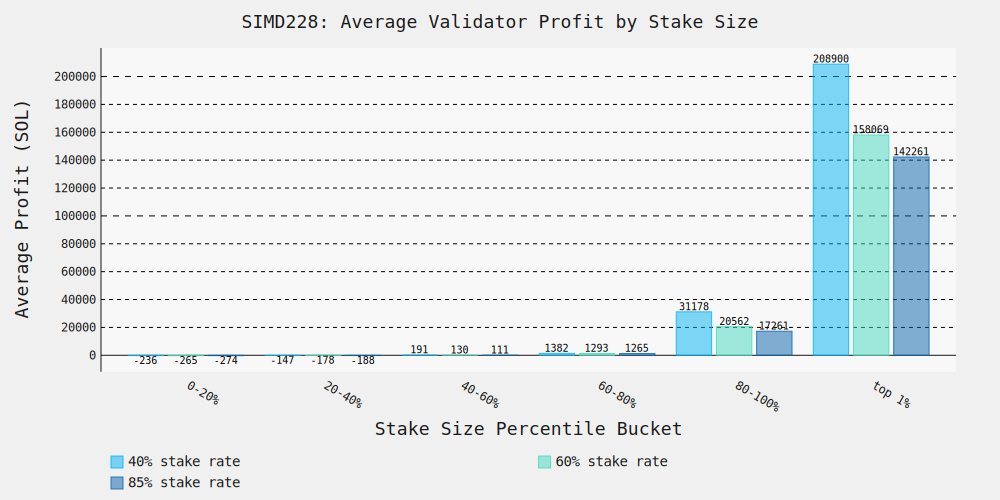

gini coefficient for low stake regime profit: 0.9248
gini coefficient for medium stake regime profit: 0.9086
gini coefficient for high stake regime profit: 0.9012
shannon entropy for low stake regime profit: 0.6556
shannon entropy for medium stake regime profit: 0.6827
shannon entropy for high stake regime profit: 0.6930


In [ ]:

def bucket_profits_with_top1(df, num_buckets=5):
    # keep only relevant columns and sort by stake
    df = df[['Active Stake (SOL)', 'Profit(SOL)']].dropna().sort_values('Active Stake (SOL)').reset_index(drop=True)
    n = len(df)
    # determine the cutoff for the top 1 percentile
    top1_cutoff = int(np.ceil(n * 0.99))
    # assign all but the top 1% to quantile buckets, top 1% to a separate bucket
    bucket_labels = [f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)] + ['top 1%']
    bucket_assignment = pd.Series([None] * n)
    # assign quantile buckets to the first 99%
    if top1_cutoff > 0:
        bucket_assignment.iloc[:top1_cutoff] = pd.qcut(
            np.arange(top1_cutoff), num_buckets, labels=[f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)]
        )
    # assign 'top 1%' to the last 1%
    bucket_assignment.iloc[top1_cutoff:] = 'top 1%'
    df['bucket'] = bucket_assignment

    grouped = df.groupby('bucket', observed=True)['Profit(SOL)']
    avg_profits = grouped.mean().reindex(bucket_labels).tolist()
    total_profits = grouped.sum().reindex(bucket_labels).tolist()
    labels = bucket_labels

    return labels, avg_profits, total_profits

# compute for each scenario
labels, low_avg, low_total = bucket_profits_with_top1(low_stake, num_buckets=5)
_, med_avg, med_total = bucket_profits_with_top1(med_stake, num_buckets=5)
_, high_avg, high_total = bucket_profits_with_top1(high_stake, num_buckets=5)

# create a custom style with smaller value font size
custom_style = pygal.style.BlueStyle(
    value_font_size=10,
    label_font_size=12,
    major_label_font_size=12,
    legend_font_size=14,
    tooltip_font_size=12,
    title_font_size=18,
)

chart = pygal.Bar(
    title='SIMD228: Average Validator Profit by Stake Size',
    x_title='Stake Size Percentile Bucket',
    y_title='Average Profit (SOL)',
    width=1000,
    height=500,
    show_legend=True,
    legend_at_bottom=True,
    style=custom_style,
    human_readable=True,
    value_formatter=lambda x: f'{x:.0f}',
    show_y_guides=True,
    print_values=True,
    print_values_position='top',
    x_label_rotation=30,  # rotate x axis labels for readability
)

chart.x_labels = labels
chart.add('40% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(low_avg, low_total)])
chart.add('60% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(med_avg, med_total)])
chart.add('85% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(high_avg, high_total)])

display(SVG(chart.render()))


# calculate and print gini coefficient for each regime's profit
low_gini = calc_modified_gini(low_stake)
med_gini = calc_modified_gini(med_stake)
high_gini = calc_modified_gini(high_stake)

low_shannon = calc_shannon_entropy(low_stake)
med_shannon = calc_shannon_entropy(med_stake)
high_shannon = calc_shannon_entropy(high_stake) 

print('gini coefficient for low stake regime profit:', f'{low_gini:.4f}')
print('gini coefficient for medium stake regime profit:', f'{med_gini:.4f}')
print('gini coefficient for high stake regime profit:', f'{high_gini:.4f}')

print('shannon entropy for low stake regime profit:', f'{low_shannon:.4f}')
print('shannon entropy for medium stake regime profit:', f'{med_shannon:.4f}')
print('shannon entropy for high stake regime profit:', f'{high_shannon:.4f}')



In [16]:
s_quo_local = s_quo.copy()

low_stake = recompute_profits(apply_simd228(change_vote_fees(s_quo_local, 0.8), 0.4))
med_stake = recompute_profits(apply_simd228(change_vote_fees(s_quo_local, 0.8), 0.6))
high_stake = recompute_profits(apply_simd228(change_vote_fees(s_quo_local, 0.8), 0.85))



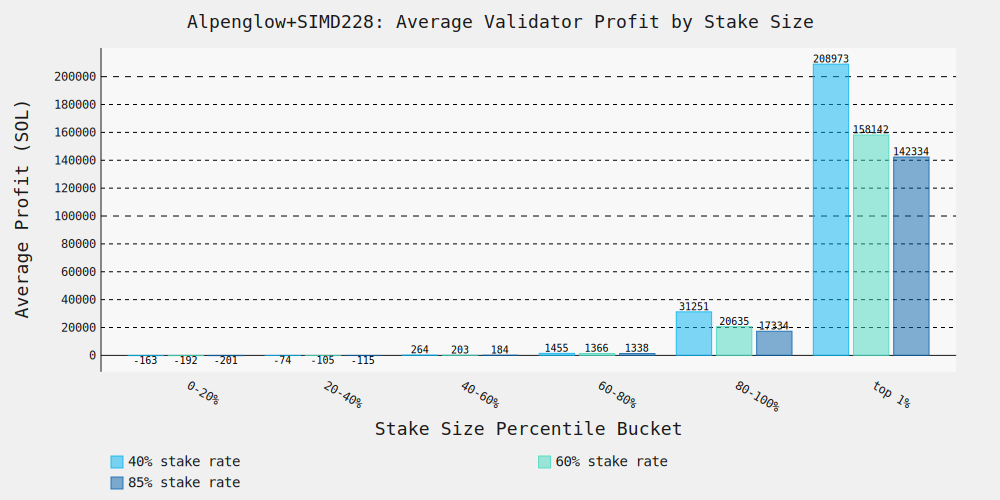

gini coefficient for alpenglow+simd228 low stake regime profit: 0.9240
gini coefficient for alpenglow+simd228 medium stake regime profit: 0.9078
gini coefficient for alpenglow+simd228 high stake regime profit: 0.9003
shannon entropy for alpenglow+simd228 low stake regime profit: 0.6583
shannon entropy for alpenglow+simd228 medium stake regime profit: 0.6860
shannon entropy for alpenglow+simd228 high stake regime profit: 0.6966


In [17]:

def bucket_profits_with_top1(df, num_buckets=5):
    # keep only relevant columns and sort by stake
    df = df[['Active Stake (SOL)', 'Profit(SOL)']].dropna().sort_values('Active Stake (SOL)').reset_index(drop=True)
    n = len(df)
    # determine the cutoff for the top 1 percentile
    top1_cutoff = int(np.ceil(n * 0.99))
    # assign all but the top 1% to quantile buckets, top 1% to a separate bucket
    bucket_labels = [f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)] + ['top 1%']
    bucket_assignment = pd.Series([None] * n)
    # assign quantile buckets to the first 99%
    if top1_cutoff > 0:
        bucket_assignment.iloc[:top1_cutoff] = pd.qcut(
            np.arange(top1_cutoff), num_buckets, labels=[f'{int(i*100/num_buckets)}-{int((i+1)*100/num_buckets)}%' for i in range(num_buckets)]
        )
    # assign 'top 1%' to the last 1%
    bucket_assignment.iloc[top1_cutoff:] = 'top 1%'
    df['bucket'] = bucket_assignment

    grouped = df.groupby('bucket', observed=True)['Profit(SOL)']
    avg_profits = grouped.mean().reindex(bucket_labels).tolist()
    total_profits = grouped.sum().reindex(bucket_labels).tolist()
    labels = bucket_labels

    return labels, avg_profits, total_profits

# compute for alpenglow+simd228 scenarios (rotor 25%)
low_labels, low_avg, low_total = bucket_profits_with_top1(low_stake, num_buckets=5)
_, med_avg, med_total = bucket_profits_with_top1(med_stake, num_buckets=5)
_, high_avg, high_total = bucket_profits_with_top1(high_stake, num_buckets=5)


# create a custom style with smaller value font size
custom_style = pygal.style.BlueStyle(
    value_font_size=10,
    label_font_size=12,
    major_label_font_size=12,
    legend_font_size=14,
    tooltip_font_size=12,
    title_font_size=18,
)

chart = pygal.Bar(
    title='Alpenglow+SIMD228: Average Validator Profit by Stake Size',
    x_title='Stake Size Percentile Bucket',
    y_title='Average Profit (SOL)',
    width=1000,
    height=500,
    show_legend=True,
    legend_at_bottom=True,
    style=custom_style,
    human_readable=True,
    value_formatter=lambda x: f'{x:.0f}',
    show_y_guides=True,
    print_values=True,
    print_values_position='top',
    x_label_rotation=30,  # rotate x axis labels for readability
)

chart.x_labels = low_labels
chart.add('40% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(low_avg, low_total)])
chart.add('60% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(med_avg, med_total)])
chart.add('85% stake rate', [{'value': avg if avg is not np.nan else 0, 'label': f'{int(tot):,}' if tot is not np.nan else '0'} for avg, tot in zip(high_avg, high_total)])

display(SVG(chart.render()))


# calculate and print gini coefficient for alpenglow+simd228 regime profits
alp_low_gini = calc_modified_gini(low_stake)
alp_med_gini = calc_modified_gini(med_stake)
alp_high_gini = calc_modified_gini(high_stake)

alp_low_shannon = calc_shannon_entropy(low_stake)
alp_med_shannon = calc_shannon_entropy(med_stake)
alp_high_shannon = calc_shannon_entropy(high_stake)

print('gini coefficient for alpenglow+simd228 low stake regime profit:', f'{alp_low_gini:.4f}')
print('gini coefficient for alpenglow+simd228 medium stake regime profit:', f'{alp_med_gini:.4f}')
print('gini coefficient for alpenglow+simd228 high stake regime profit:', f'{alp_high_gini:.4f}')

print('shannon entropy for alpenglow+simd228 low stake regime profit:', f'{alp_low_shannon:.4f}')
print('shannon entropy for alpenglow+simd228 medium stake regime profit:', f'{alp_med_shannon:.4f}')
print('shannon entropy for alpenglow+simd228 high stake regime profit:', f'{alp_high_shannon:.4f}')